In [1]:
import os
try:
    inpath = "../input/data/" #Kaggle
    print(os.listdir(inpath))
except FileNotFoundError:
    inpath = "./" #Local
    print(os.listdir(inpath))

['images_003', 'images_012', 'LOG_CHESTXRAY.pdf', 'README_CHESTXRAY.pdf', 'BBox_List_2017.csv', 'images_009', 'images_008', 'images_007', 'test_list.txt', 'images_010', 'ARXIV_V5_CHESTXRAY.pdf', 'images_002', 'images_011', 'Data_Entry_2017.csv', 'images_001', 'train_val_list.txt', 'images_005', 'FAQ_CHESTXRAY.pdf', 'images_004', 'images_006']


In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Found GPU at: /device:GPU:0


In [3]:
import pandas as pd
data = pd.read_csv(inpath + 'Data_Entry_2017.csv')
print(f"The dimensions of the data set are: {data.shape}")

data.head()

The dimensions of the data set are: (112120, 12)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [4]:
data = data[data['Patient Age']<100]
print(f"The dimensions of the data set are: {data.shape}")

The dimensions of the data set are: (112104, 12)


In [5]:
data = data[['Image Index', 'Finding Labels']]
print(f"The dimensions of the data set are: {data.shape}")

The dimensions of the data set are: (112104, 2)


In [6]:
"""
We read all the routes of the images
"""
from glob import glob
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('..', 'input','data','images*','images','*.png'))}
print('Images found:', len(all_image_paths))

"""
Add the path column to the dataset
"""
data['Path'] = data['Image Index'].map(all_image_paths.get)

data.sample(5, random_state=3)

Images found: 112120


,Image Index,Finding Labels,Path
13531,00003520_002.png,No Finding,../input/data/images_002/images/00003520_002.png
45241,00011598_037.png,Effusion|Mass,../input/data/images_006/images/00011598_037.png
40313,00010503_000.png,Infiltration,../input/data/images_005/images/00010503_000.png
81272,00019962_006.png,No Finding,../input/data/images_009/images/00019962_006.png
85415,00021047_013.png,No Finding,../input/data/images_010/images/00021047_013.png


In [7]:
"""
Create a np array with all the single deseases
"""
import numpy as np
from itertools import chain
all_labels = np.unique(list(chain(*data['Finding Labels'].map(lambda x: x.split('|')).tolist())))

all_labels

array(['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration',
       'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia',
       'Pneumothorax'], dtype='<U18')

In [8]:
all_labels = np.delete(all_labels, np.where(all_labels == 'No Finding'))
print(f'Current type: {type(all_labels)}')

all_labels = [x for x in all_labels]
print(f'Final type: {type(all_labels)}')

print(f'Diseases: ({len(all_labels)}): {all_labels}')

Current type: <class 'numpy.ndarray'>
Final type: <class 'list'>
Diseases: (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [9]:
"""
We add a column, for each disease
"""
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        # Add a column for each desease
        data[c_label] = data['Finding Labels'].map(lambda finding: 1 if c_label in finding else 0)
        
print(f"The dimensions of the data set are: {data.shape}")
data.head()

The dimensions of the data set are: (112104, 17)


,Image Index,Finding Labels,Path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,../input/data/images_001/images/00000001_000.png,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,../input/data/images_001/images/00000001_001.png,0,1,0,0,0,1,0,0,0,0,0,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,../input/data/images_001/images/00000001_002.png,0,1,0,0,1,0,0,0,0,0,0,0,0,0
3,00000002_000.png,No Finding,../input/data/images_001/images/00000002_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,00000003_000.png,Hernia,../input/data/images_001/images/00000003_000.png,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [10]:
label_counts = data['Finding Labels'].value_counts()
label_counts

No Finding                                                                   60353
Infiltration                                                                  9546
Atelectasis                                                                   4214
Effusion                                                                      3955
Nodule                                                                        2705
                                                                             ...  
Effusion|Fibrosis|Mass|Cardiomegaly                                              1
Emphysema|Mass|Nodule|Pleural_Thickening|Pneumothorax                            1
Fibrosis|Hernia|Mass                                                             1
Atelectasis|Consolidation|Effusion|Infiltration|Nodule|Pleural_Thickening        1
Atelectasis|Emphysema|Fibrosis|Nodule                                            1
Name: Finding Labels, Length: 836, dtype: int64

In [11]:
data = data.groupby('Finding Labels').filter(lambda x : len(x)>11)

In [12]:
label_counts = data['Finding Labels'].value_counts()
print(label_counts.shape)
label_counts

(198,)


No Finding                                                      60353
Infiltration                                                     9546
Atelectasis                                                      4214
Effusion                                                         3955
Nodule                                                           2705
                                                                ...  
Emphysema|Fibrosis                                                 13
Cardiomegaly|Consolidation|Infiltration                            12
Atelectasis|Nodule|Pleural_Thickening                              12
Effusion|Emphysema|Infiltration|Pneumothorax                       12
Atelectasis|Cardiomegaly|Consolidation|Effusion|Infiltration       12
Name: Finding Labels, Length: 198, dtype: int64

In [13]:
from sklearn.model_selection import train_test_split

train_and_valid_df, test_df = train_test_split(data,
                                               test_size = 0.30,
                                               random_state = 2018,
                                              )

train_df, valid_df = train_test_split(train_and_valid_df,
                                      test_size=0.30,
                                      random_state=2018,
                                     )

print(f'Training : {train_df.shape[0]} Validation: {valid_df.shape[0]} Testing: {test_df.shape[0]}')

Training : 54091 Validation: 23183 Testing: 33118


In [14]:
from keras_preprocessing.image import ImageDataGenerator
base_generator = ImageDataGenerator(rescale=1./255)

In [15]:
IMG_SIZE = (224, 224)
def flow_from_dataframe(image_generator, dataframe, batch_size):

    df_gen = image_generator.flow_from_dataframe(dataframe,
                                                 x_col='Path',
                                                 y_col=all_labels,
                                                 target_size=IMG_SIZE,
                                                 classes=all_labels,
                                                 color_mode='rgb',
                                                 class_mode='raw',
                                                 shuffle=False,
                                                 batch_size=batch_size)
    
    return df_gen

In [16]:
train_gen = flow_from_dataframe(image_generator=base_generator, 
                                dataframe= train_df,
                                batch_size = 32)

valid_gen = flow_from_dataframe(image_generator=base_generator, 
                                dataframe=valid_df,
                                batch_size = 32)

test_gen = flow_from_dataframe(image_generator=base_generator, 
                               dataframe=test_df,
                               batch_size = 32)

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:220: UserWarning: `classes` will be ignored given the class_mode="raw"
  .format(self.class_mode))


Found 54091 validated image filenames.
Found 23183 validated image filenames.
Found 33118 validated image filenames.


In [17]:
train_x, train_y = next(train_gen)
print(f"Image dimensions: {train_x[1].shape}")
print(f"Diseases vector: {train_y[1]}")


Image dimensions: (224, 224, 3)
Diseases vector: [0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [18]:
import tensorflow as tf
try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError: # no TPU found, detect GPUs
    strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
    #strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines

print("Number of accelerators: ", strategy.num_replicas_in_sync)

Number of accelerators:  1


In [19]:
from keras.layers import Input
from keras.applications.vgg16 import VGG16
from keras.layers.core import Dense
from keras.models import Model


input_shape=(224, 224, 3)
img_input = Input(shape=input_shape)

base_model = VGG16(include_top=False, input_tensor=img_input, input_shape=input_shape, 
                         pooling="avg", weights='imagenet')
x = base_model.output
predictions = Dense(len(all_labels), activation="sigmoid", name="predictions")(x)
model = Model(inputs=img_input, outputs=predictions)



# train model normally
#model.fit(training_dataset, epochs=EPOCHS, steps_per_epoch=…)

58892288/58889256 [==============================] - 1s 0us/step


In [20]:
from contextlib import redirect_stdout

with open('model_summary.txt', 'w') as f:
    with redirect_stdout(f):
        model.summary()

In [21]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
model_train = model
output_weights_name='weights.h5'
checkpoint = ModelCheckpoint(
             output_weights_name,
             save_weights_only=True,
             save_best_only=True,
             verbose=1,)

In [22]:
import keras.backend as kb
from keras.callbacks import Callback
from sklearn.metrics import roc_auc_score
import shutil
import warnings   
import json

In [23]:
class MultipleClassAUROC(Callback):
    """
    Monitor mean AUROC and update model
    """
    def __init__(self, generator, class_names, weights_path, stats=None):
        super(Callback, self).__init__()
        self.generator = generator
        self.class_names = class_names
        self.weights_path = weights_path
        self.best_weights_path = os.path.join(
            os.path.split(weights_path)[0],
            f"best_{os.path.split(weights_path)[1]}",
        )
        self.best_auroc_log_path = os.path.join(
            os.path.split(weights_path)[0],
            "best_auroc.log",
        )
        self.stats_output_path = os.path.join(
            os.path.split(weights_path)[0],
            ".training_stats.json"
        )
        # for resuming previous training
        if stats:
            self.stats = stats
        else:
            self.stats = {"best_mean_auroc": 0}

        # aurocs log
        self.aurocs = {}
        for c in self.class_names:
            self.aurocs[c] = []
    def on_epoch_end(self, epoch, logs={}):
        """
        Calculate the average of the ROC Curves and save the best group of weights
        according to this metric
        """
        print("\n*********************************")
        self.stats["lr"] = float(kb.eval(self.model.optimizer.lr))
        print(f"Learning Rate actual: {self.stats['lr']}")

        """
        y_hat shape: (#examples, len(labels))
        y: [(#examples, 1), (#examples, 1) ... (#examples, 1)]
        """
        y_hat = self.model.predict_generator(self.generator,steps=self.generator.n/self.generator.batch_size)
        y = self.generator.labels
        
        print(f"*** epoch#{epoch + 1} ROC Curves Training Phase ***")
        current_auroc = []
        for i in range(len(self.class_names)):
            try:
                score = roc_auc_score(y[:, i], y_hat[:, i])
            except ValueError:
                score = 0
            self.aurocs[self.class_names[i]].append(score)
            current_auroc.append(score)
            print(f"{i+1}. {self.class_names[i]}: {score}")   
        print("*********************************")

        mean_auroc = np.mean(current_auroc)
        print(f"Average ROC Curves: {mean_auroc}")
        if mean_auroc > self.stats["best_mean_auroc"]:
            print(f"Update of the result of the ROC Curves of: {self.stats['best_mean_auroc']} a {mean_auroc}")
            # 1. copy best model
            shutil.copy(self.weights_path, self.best_weights_path)

            # 2. update log file
            print(f"Updating the log file: {self.best_auroc_log_path}")
            with open(self.best_auroc_log_path, "a") as f:
                f.write(f"(epoch#{epoch + 1}) auroc: {mean_auroc}, lr: {self.stats['lr']}\n")

            # 3. write stats output, this is used for resuming the training
            with open(self.stats_output_path, 'w') as f:
                json.dump(self.stats, f)

            print(f"Weight group update: {self.weights_path} -> {self.best_weights_path}")
            self.stats["best_mean_auroc"] = mean_auroc
            print("*********************************")
        return

In [24]:
training_stats = {}
auroc = MultipleClassAUROC(
    generator=valid_gen,
    class_names=all_labels,
    weights_path=output_weights_name,
    stats=training_stats
)

In [25]:
from keras.optimizers import Adam
initial_learning_rate=1e-3
optimizer = Adam(lr=initial_learning_rate)
model_train.compile(optimizer=optimizer, loss="binary_crossentropy")

In [26]:
from keras.callbacks import TensorBoard, ReduceLROnPlateau
#TODO - VALIDATE THE LOGS OUTPUT
logs_base_dir = '../working/'
patience_reduce_lr=2
min_lr=1e-8
callbacks = [
            checkpoint,
            TensorBoard(log_dir=os.path.join(logs_base_dir, "logs"), batch_size=train_gen.batch_size),
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=patience_reduce_lr,
                              verbose=1, mode="min", min_lr=min_lr),
            auroc,
        ]


In [27]:
epochs=10
fit_history = model.fit_generator(
    generator=train_gen,
    steps_per_epoch=train_gen.n/train_gen.batch_size,
    epochs=epochs,
    validation_data=valid_gen,
    validation_steps=valid_gen.n/valid_gen.batch_size,
    callbacks=callbacks, 
    shuffle=False    
)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
1690/1690 [==============================] - 2709s 2s/step - loss: 0.2328 - val_loss: 0.1732

Epoch 00001: val_loss improved from inf to 0.17319, saving model to weights.h5

*********************************
Learning Rate actual: 0.0010000000474974513


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


*** epoch#1 ROC Curves Training Phase ***
1. Atelectasis: 0.550531107371403
2. Cardiomegaly: 0.5860145685735108
3. Consolidation: 0.6485330203161805
4. Edema: 0.6919460953359259
5. Effusion: 0.6416868104807665
6. Emphysema: 0.5245061127587175
7. Fibrosis: 0.4528208707231031
8. Hernia: 0.49079548399637163
9. Infiltration: 0.601123268484097
10. Mass: 0.508470546530248
11. Nodule: 0.4704761389573953
12. Pleural_Thickening: 0.5438495551978539
13. Pneumonia: 0.6180195631347991
14. Pneumothorax: 0.5804568932104772
*********************************
Average ROC Curves: 0.5649450025050605
Update of the result of the ROC Curves of: 0 a 0.5649450025050605
Updating the log file: best_auroc.log
Weight group update: weights.h5 -> best_weights.h5
*********************************
Epoch 2/10
1690/1690 [==============================] - 2582s 2s/step - loss: 0.1714 - val_loss: 0.1676

Epoch 00002: val_loss improved from 0.17319 to 0.16760, saving model to weights.h5

*********************************
L

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


*** epoch#2 ROC Curves Training Phase ***
1. Atelectasis: 0.6330124107615123
2. Cardiomegaly: 0.6204075153369688
3. Consolidation: 0.7294933666900074
4. Edema: 0.8207077291823055
5. Effusion: 0.7098267477462911
6. Emphysema: 0.5572896516895608
7. Fibrosis: 0.5706954854117101
8. Hernia: 0.540381624983802
9. Infiltration: 0.6374204208439422
10. Mass: 0.5317224139406331
11. Nodule: 0.5397958331947267
12. Pleural_Thickening: 0.5696148645185207
13. Pneumonia: 0.6707559534756953
14. Pneumothorax: 0.6322035641754332
*********************************
Average ROC Curves: 0.625951970139365
Update of the result of the ROC Curves of: 0.5649450025050605 a 0.625951970139365
Updating the log file: best_auroc.log
Weight group update: weights.h5 -> best_weights.h5
*********************************
Epoch 3/10
1690/1690 [==============================] - 2630s 2s/step - loss: 0.1671 - val_loss: 0.1637

Epoch 00003: val_loss improved from 0.16760 to 0.16369, saving model to weights.h5

*******************

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


*** epoch#3 ROC Curves Training Phase ***
1. Atelectasis: 0.6922826178771673
2. Cardiomegaly: 0.6202956156409282
3. Consolidation: 0.7616874013225359
4. Edema: 0.8178227140091547
5. Effusion: 0.7861284065235549
6. Emphysema: 0.6365218552787233
7. Fibrosis: 0.5794990145441333
8. Hernia: 0.6882640058744762
9. Infiltration: 0.6515386492130338
10. Mass: 0.5883962379073033
11. Nodule: 0.5662268334910652
12. Pleural_Thickening: 0.6417236029600684
13. Pneumonia: 0.6614116501326195
14. Pneumothorax: 0.6927139446073717
*********************************
Average ROC Curves: 0.6703223249558666
Update of the result of the ROC Curves of: 0.625951970139365 a 0.6703223249558666
Updating the log file: best_auroc.log
Weight group update: weights.h5 -> best_weights.h5
*********************************
Epoch 4/10
1690/1690 [==============================] - 2421s 1s/step - loss: 0.1634 - val_loss: 0.1613

Epoch 00004: val_loss improved from 0.16369 to 0.16131, saving model to weights.h5

*****************

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


*** epoch#4 ROC Curves Training Phase ***
1. Atelectasis: 0.7240252516667015
2. Cardiomegaly: 0.7161928708041319
3. Consolidation: 0.7652024478281149
4. Edema: 0.8198502533248296
5. Effusion: 0.8161736160661968
6. Emphysema: 0.6542279774033428
7. Fibrosis: 0.6438914295746755
8. Hernia: 0.774731653060343
9. Infiltration: 0.6511005650740332
10. Mass: 0.6285488595318754
11. Nodule: 0.5827610723300777
12. Pleural_Thickening: 0.6643788203177704
13. Pneumonia: 0.689309115404473
14. Pneumothorax: 0.7176219776977149
*********************************
Average ROC Curves: 0.7034297078631628
Update of the result of the ROC Curves of: 0.6703223249558666 a 0.7034297078631628
Updating the log file: best_auroc.log
Weight group update: weights.h5 -> best_weights.h5
*********************************
Epoch 5/10
1690/1690 [==============================] - 2559s 2s/step - loss: 0.1609 - val_loss: 0.1580

Epoch 00005: val_loss improved from 0.16131 to 0.15796, saving model to weights.h5

******************

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


*** epoch#5 ROC Curves Training Phase ***
1. Atelectasis: 0.7360206886048368
2. Cardiomegaly: 0.8376471363351385
3. Consolidation: 0.7739057344273157
4. Edema: 0.8351069834120681
5. Effusion: 0.8317890247303485
6. Emphysema: 0.6936562955268418
7. Fibrosis: 0.6464087444599507
8. Hernia: 0.8012558852749341
9. Infiltration: 0.6612004106945222
10. Mass: 0.6618697582156152
11. Nodule: 0.599239804935454
12. Pleural_Thickening: 0.6818286377455212
13. Pneumonia: 0.7054683120204036
14. Pneumothorax: 0.7464285781840555
*********************************
Average ROC Curves: 0.7294161424690718
Update of the result of the ROC Curves of: 0.7034297078631628 a 0.7294161424690718
Updating the log file: best_auroc.log
Weight group update: weights.h5 -> best_weights.h5
*********************************
Epoch 6/10
1690/1690 [==============================] - 2407s 1s/step - loss: 0.1580 - val_loss: 0.1567

Epoch 00006: val_loss improved from 0.15796 to 0.15665, saving model to weights.h5

*****************

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


*** epoch#6 ROC Curves Training Phase ***
1. Atelectasis: 0.7452002748538049
2. Cardiomegaly: 0.8630145534095331
3. Consolidation: 0.7799112807935377
4. Edema: 0.8438389294321497
5. Effusion: 0.8399594336095985
6. Emphysema: 0.7098122544665862
7. Fibrosis: 0.6702228922957817
8. Hernia: 0.8319794501317438
9. Infiltration: 0.6595224453403515
10. Mass: 0.6787423553249596
11. Nodule: 0.6089447933092824
12. Pleural_Thickening: 0.6891521185728561
13. Pneumonia: 0.710238792708031
14. Pneumothorax: 0.770184395894431
*********************************
Average ROC Curves: 0.742908855010189
Update of the result of the ROC Curves of: 0.7294161424690718 a 0.742908855010189
Updating the log file: best_auroc.log
Weight group update: weights.h5 -> best_weights.h5
*********************************
Epoch 7/10
1690/1690 [==============================] - 2549s 2s/step - loss: 0.1557 - val_loss: 0.1564

Epoch 00007: val_loss improved from 0.15665 to 0.15635, saving model to weights.h5

********************

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


*** epoch#7 ROC Curves Training Phase ***
1. Atelectasis: 0.7490861342701283
2. Cardiomegaly: 0.8627019924594943
3. Consolidation: 0.774460355880034
4. Edema: 0.8496557115201182
5. Effusion: 0.8419483957389806
6. Emphysema: 0.7102399728530755
7. Fibrosis: 0.660677428856538
8. Hernia: 0.7925184117316746
9. Infiltration: 0.6613555230819185
10. Mass: 0.6897072925637002
11. Nodule: 0.6091157563237433
12. Pleural_Thickening: 0.6835823517565547
13. Pneumonia: 0.7047606200877041
14. Pneumothorax: 0.7679778521001135
*********************************
Average ROC Curves: 0.7398419856588412
Epoch 8/10
1690/1690 [==============================] - 2274s 1s/step - loss: 0.1537 - val_loss: 0.1558

Epoch 00008: val_loss improved from 0.15635 to 0.15578, saving model to weights.h5

*********************************
Learning Rate actual: 0.0010000000474974513


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


*** epoch#8 ROC Curves Training Phase ***
1. Atelectasis: 0.7513772180994853
2. Cardiomegaly: 0.8686128934594628
3. Consolidation: 0.7773144934465825
4. Edema: 0.8573186700305345
5. Effusion: 0.8414967546145962
6. Emphysema: 0.722209524448108
7. Fibrosis: 0.6627608470213956
8. Hernia: 0.812568841518725
9. Infiltration: 0.6635586180744518
10. Mass: 0.7008278526034573
11. Nodule: 0.609105112860386
12. Pleural_Thickening: 0.6956653750368373
13. Pneumonia: 0.7003353527251078
14. Pneumothorax: 0.7810312264599525
*********************************
Average ROC Curves: 0.7460130557427916
Update of the result of the ROC Curves of: 0.742908855010189 a 0.7460130557427916
Updating the log file: best_auroc.log
Weight group update: weights.h5 -> best_weights.h5
*********************************
Epoch 9/10
1690/1690 [==============================] - 2312s 1s/step - loss: 0.1519 - val_loss: 0.1588

Epoch 00009: val_loss did not improve from 0.15578

*********************************
Learning Rate actu

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


*** epoch#9 ROC Curves Training Phase ***
1. Atelectasis: 0.7436284599234378
2. Cardiomegaly: 0.8640696699359853
3. Consolidation: 0.7659005725568341
4. Edema: 0.8526381810280115
5. Effusion: 0.840447928827745
6. Emphysema: 0.7079229764552225
7. Fibrosis: 0.6552733522897637
8. Hernia: 0.8195312837458426
9. Infiltration: 0.658996245282042
10. Mass: 0.6934348000740177
11. Nodule: 0.6056941880433698
12. Pleural_Thickening: 0.6856107295256676
13. Pneumonia: 0.7098990267181634
14. Pneumothorax: 0.7723687817006724
*********************************
Average ROC Curves: 0.7411011568647696
Epoch 10/10
1690/1690 [==============================] - 2188s 1s/step - loss: 0.1490 - val_loss: 0.1627

Epoch 00010: val_loss did not improve from 0.15578

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

*********************************
Learning Rate actual: 0.00010000000474974513


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


*** epoch#10 ROC Curves Training Phase ***
1. Atelectasis: 0.7332231537788922
2. Cardiomegaly: 0.8641476685558892
3. Consolidation: 0.7539673245366534
4. Edema: 0.8474299241248394
5. Effusion: 0.8353534692357785
6. Emphysema: 0.7109786462759631
7. Fibrosis: 0.6363778904634207
8. Hernia: 0.811690099779707
9. Infiltration: 0.6542960969651795
10. Mass: 0.6909131795904827
11. Nodule: 0.5987295862950647
12. Pleural_Thickening: 0.6955373070589261
13. Pneumonia: 0.6805816535228932
14. Pneumothorax: 0.767283703583406
*********************************
Average ROC Curves: 0.7343221216976497


In [28]:
# serialize model to JSON                        
model_json = model.to_json() 
with open("model.json", "w") as json_file:                     
    json_file.write(model_json)  
# serialize weights to HDF5
model.save_weights("model-w.h5")           
print("Saved model to disk") 

Saved model to disk


In [29]:
model.save("model.h5")  
print("Saved model to disk")

Saved model to disk


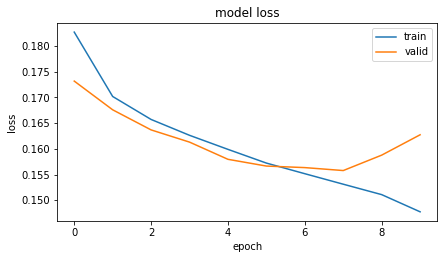

In [30]:
import matplotlib.pyplot as plt  

plt.figure(1, figsize = (15,8))  
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [31]:
fit_history.history.keys()

dict_keys(['loss', 'val_loss', 'lr'])

In [ ]:
model.load_weights('model-w.h5')